### Задание
Провести мини-исследование рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов. 
- Рассчитать средние цены за квадратный метр по регионам. Важно чтобы пропуски не учитывались при расчете средней цены. 
- Рассчитать объемы вводимого жилья по регионам и по годам. 
- Сравнить этажность домов, количество квартир, жилую площадь, количество парковочных мест и цену за квадратный метр в разных регионах 
- Визуализировать разброс, связь и распределение этих показателей по регионам 
- Сделать выводы по каждому из расчетов и графиков

In [1]:
import requests
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
offset_ = 1
limit_ = 100
url_ = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset_}&limit={limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
res = requests.get(url_)
obj = res.json()
obj_list = obj.get('data').get('list')
id_obj = [x.get('objId') for x in obj_list]

In [3]:
def df_objects(url_, obj_id):
    
    df = pd.DataFrame()
    
    for i in obj_id:
        url = url_ + '/' + str(i)
        res = requests.get(url)
        ob = res.json().get('data')
        dff = pd.json_normalize(ob)
        df = pd.concat([df, dff])

    return df

In [4]:
df = df_objects(f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object', id_obj)


In [5]:
list(df.columns)

['id',
 'pdId',
 'region',
 'address',
 'floorMin',
 'floorMax',
 'objElemLivingCnt',
 'objReady100PercDt',
 'wallMaterialShortDesc',
 'objLkFinishTypeDesc',
 'objLkFreePlanDesc',
 'objElemParkingCnt',
 'objSquareLiving',
 'rpdNum',
 'rpdPdfLink',
 'rpdIssueDttm',
 'objLkLatitude',
 'objLkLongitude',
 'objCompensFundFlg',
 'objProblemFlg',
 'objLkClassDesc',
 'loadDttm',
 'photoRenderDTO',
 'objGuarantyEscrowFlg',
 'objectType',
 'miniUrl',
 'residentialBuildings',
 'newBuildingId',
 'objFloorCnt',
 'objFlatCnt',
 'objFlatSq',
 'objNonlivElemCnt',
 'objStatus',
 'isAvailableWantLiveHere',
 'objTransferPlanDt',
 'objLivCeilingHeight',
 'objInfrstrBicycleLaneFlg',
 'objInfrstrPlaygrndCnt',
 'objInfrstrSportGroundCnt',
 'objInfrstrTrashAreaCnt',
 'objInfrstrObjPrkngCnt',
 'objInfrstrNotObjPrkngCnt',
 'objInfrstrRampFlg',
 'objInfrstrCurbLoweringFlg',
 'objElevatorWheelchairCnt',
 'objElevatorPassengerCnt',
 'objElevatorCargoCnt',
 'soldOutPerc',
 'objPriceAvg',
 'generalContractorNm',
 'n

Рассчитать средние цены за квадратный метр по регионам. Важно чтобы пропуски не учитывались при расчете средней цены.

In [6]:
# определяем среднюю цену за кв м по регионам из тех данных, где данные не пропущены
avg = df[~df['objPriceAvg'].isnull()].groupby('region')['objPriceAvg'].mean()
# приводим датафрейм к типу данных - словарь
g = dict(avg)
# удаляем из основного датафрейма индекс
df = df.reset_index(drop='index')

In [7]:
# заполняем пропущенные значения в столбце со средней ценой в зависимости от средней цены в регионе

for i in g:
    df.loc[df[(df.region.isin([i]))&(df.objPriceAvg.isnull())].index, 'objPriceAvg'] = g[i]

In [ ]:
# то же самое что выше, но не работает
# for i, j in enumerate(g):
#     if df['region'] == j:
#         df.loc[(df['objPriceAvg'].isnull()), 'objPriceAvg'] = g[j]
# #     df.objPriceAvg.where((df['objPriceAvg'].isnull()), g[j], inplace=True)
    
# len(df['objPriceAvg'].isnull())

In [ ]:
# df['objPriceAvg'] = df[df['objPriceAvg'].isnull()].apply(
#                 lambda x: g[j] for i, j in enumerate(g) if (df['region'] == j)
#                                 )

In [8]:
# приводим кдату к типу данных дата, а сокращенное название орг фромы к строке
df = df.astype({
    'objReady100PercDt': np.datetime64,
    'developer.orgForm.shortForm' : str,
    })

<AxesSubplot:ylabel='Frequency'>

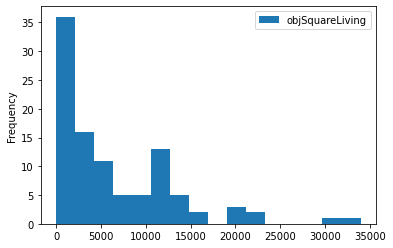

In [9]:
# гистограмма распределения стоимости по площади квартиры
df_reg = df[['objSquareLiving','objPriceAvg']].set_index('objPriceAvg')

df_reg.plot(kind='hist', bins=16)
plt.show()

In [10]:
# создание датафрейма - группировка по региону и агрегирование по средней цене
df_regprice = df.groupby('region')['objPriceAvg'].mean().reset_index()

In [11]:
# создаем функцию постороения столбцатого графика
def sns_bar_plot(df, bar_color: str, plot_title, xlable, ylable):
    sns.barplot( df[df.columns[0]], df[df.columns[1]], color=bar_color)
    plt.ylabel(ylable)
    plt.xlabel(xlable)
    plt.title(plot_title, size=15, color='b')

/Users/olgakamskaa/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


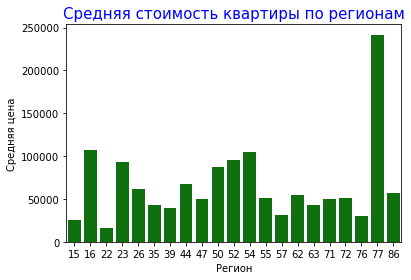

In [12]:
# передаем в функцию датафрейм, цвет столбцов, название осей
sns_bar_plot(df_regprice, 'g', 'Cредняя стоимость квартиры по регионам', 'Регион','Средняя цена')

/Users/olgakamskaa/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


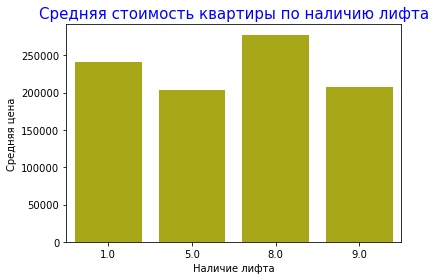

In [13]:
# по своему желанию график цены квартиры в зависимости от вместимости лифта
df_green_area = df.groupby('greenAreaIndexValue')['objPriceAvg'].mean().sort_index().reset_index()

sns_bar_plot(df_green_area, 'y', 'Cредняя стоимость квартиры по наличию лифта', 'Наличие лифта','Средняя цена')

In [14]:
from pylab import rcParams
#     rcParams['figure.figsize'] = 9,20
# plt.show()

In [38]:
# функция для построения линейного графика
def graf(df,row,col):
    fig, ax = plt.subplots(nrows=row,ncols=col)
#     fig.tight_layout(h_pad=10)
    ax1, ax2, ax3 = ax.flatten()
    ax1.plot(df.index, df[df.columns[0]])
    ax2.plot(df.index, df[df.columns[1]])
    ax3.plot(df.index, df[df.columns[2]])
    ax1.set_title(df.columns[0])
    ax2.set_title(df.columns[1])
    ax3.set_title(df.columns[2])
    fig.set_size_inches(8,7)
    plt.subplots_adjust(wspace=5, hspace=1.1)

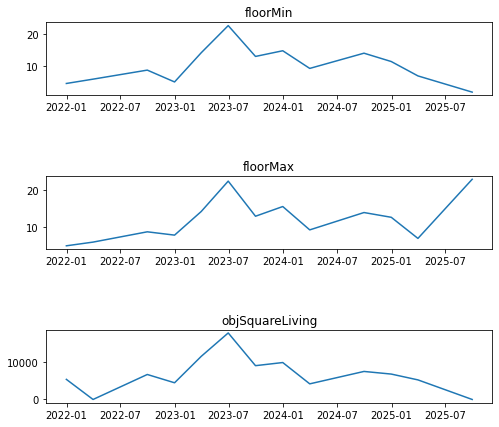

In [39]:
dat = df.groupby('objReady100PercDt')[['floorMin', 'floorMax', 'objSquareLiving']].mean()

graf(dat, 3,1)
# plt.plot(df.)

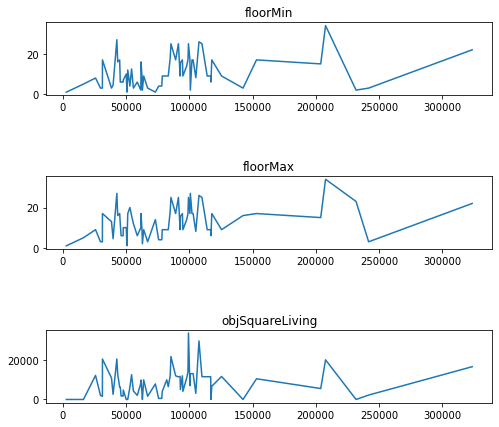

In [40]:
price = df.groupby('objPriceAvg')[['floorMin', 'floorMax', 'objSquareLiving']].mean()
graf(price, 3,1)

Рассчитать объемы вводимого жилья по регионам и по годам.

In [52]:
# создаем 2 датафрейма

volum_reg = df.groupby('region')[['objElemLivingCnt']].sum()
volum_dat = df.groupby('objReady100PercDt')[['objElemLivingCnt']].sum().reset_index()

<BarContainer object of 21 artists>

Text(0.5, 1.0, 'objReady100PercDt')

Text(0.5, 1.0, 'objElemLivingCnt')

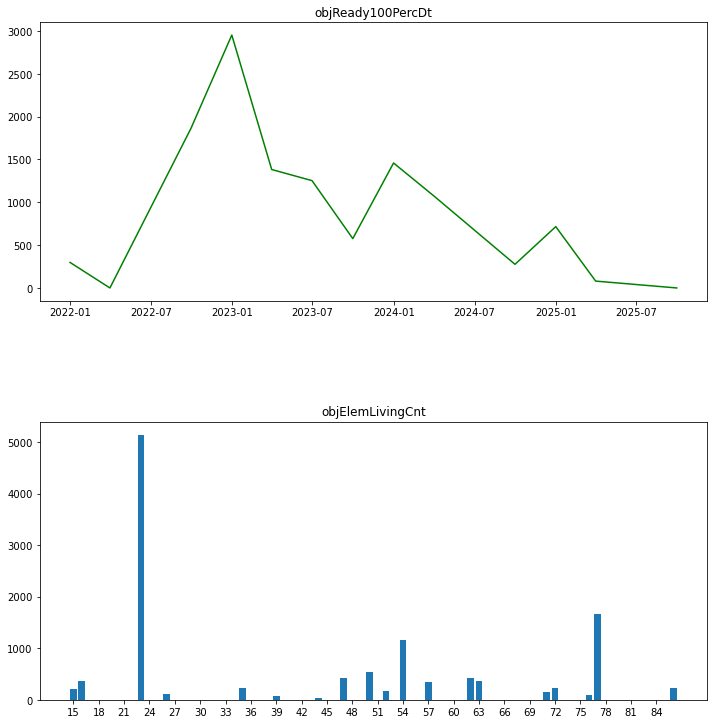

In [55]:
# строим линейный график по средней цене за квадрат в зависимости от сдачи квратриры и
# столбчатый график в зависимости отсредней цены в регионе
fig, ax = plt.subplots(figsize = (10, 10),nrows=2,ncols=1)
fig.tight_layout(h_pad=10)
x_range = list(range(int(volum_reg.index.min()), int(volum_reg.index.max()) + 1, 3))
ax1, ax2 = ax.flatten()
ax1.plot(volum_dat.objReady100PercDt, volum_dat.objElemLivingCnt, color='g')
ax2.bar(volum_reg.index, volum_reg.objElemLivingCnt)
ax1.set_title(volum_dat.columns[0])
ax2.set_title(volum_reg.columns[0])
ax2.set_xticks(x_range)
plt.subplots_adjust(wspace=1)
plt.show()

Сравнить этажность домов, количество квартир, жилую площадь, количество парковочных мест и цену за квадратный метр в разных регионах

In [23]:
# создаем функцию
def graf2(df,row,col):
    fig, ax = plt.subplots(figsize = (12, 26), nrows=row,ncols=col)
    fig.tight_layout(h_pad=10)
    x_range = list(range(int(df.index.min()), int(df.index.max()) + 1, 3))
    ax1, ax2, ax3, ax4, ax5 = ax.flatten()
    ax1.bar(df.index, df[df.columns[0]])
    ax2.bar(df.index, df[df.columns[1]])
    ax3.bar(df.index, df[df.columns[2]])
    ax4.bar(df.index, df[df.columns[3]])
    ax5.bar(df.index, df[df.columns[4]])
    ax1.set_title(df.columns[0])
    ax2.set_title(df.columns[1])
    ax3.set_title(df.columns[2])
    ax4.set_title(df.columns[3])
    ax5.set_title(df.columns[4])
    ax1.set_xticks(x_range)
    ax2.set_xticks(x_range)
    ax3.set_xticks(x_range)
    ax4.set_xticks(x_range)
    ax5.set_xticks(x_range)
    ax1.grid(color='green', linestyle='--')
    ax2.grid(color='yellow', linestyle='-')
    fig.set_size_inches(8,7)
    plt.subplots_adjust(wspace=1)

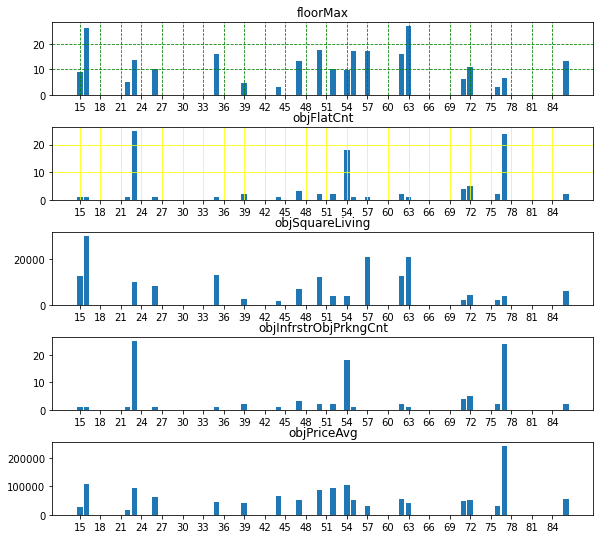

In [24]:
# создаем датафрейм
reg_obj = df.groupby('region').agg({
                                'floorMax': 'mean',
                                'objFlatCnt' : 'count',
                                'objSquareLiving': 'mean',
                                'objInfrstrObjPrkngCnt': 'count',
                                'objPriceAvg': 'mean'
})
graf2(reg_obj, 5, 1)